In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set(style="whitegrid")


In [2]:
# Load historical match data (CSV)
matches = pd.read_csv('/content/results.csv', encoding='ISO-8859-1')
print("Historical matches loaded:", matches.shape)

# Load current standings data (Excel)
standings = pd.read_excel('/content/Points_table_2025.xlsx')
print("Current standings loaded:", standings.shape)

# Load remaining fixtures (CSV) with columns: HomeTeam, AwayTeam
fixtures = pd.read_excel('/content/Matches_left.xlsx')
print("Remaining fixtures loaded:", fixtures.shape)


Historical matches loaded: (6769, 23)
Current standings loaded: (20, 10)
Remaining fixtures loaded: (161, 2)


In [3]:
# Define a mapping to standardize team names (adjust as needed)
name_mapping = {
    'AFC Bournemouth': 'Bournemouth',
    # Add more mappings if needed
}

# Standardize names in historical matches for both HomeTeam and AwayTeam
matches['HomeTeam'] = matches['HomeTeam'].replace(name_mapping)
matches['AwayTeam'] = matches['AwayTeam'].replace(name_mapping)

# Standardize names in fixtures
fixtures['HomeTeam'] = fixtures['HomeTeam'].replace(name_mapping)
fixtures['AwayTeam'] = fixtures['AwayTeam'].replace(name_mapping)

# Also standardize current standings if necessary
standings['Team'] = standings['Team'].replace(name_mapping)


In [4]:
# Build Poisson regression model for home goals
formula_home = 'FTHG ~ C(HomeTeam) + C(AwayTeam)'
poisson_model_home = smf.glm(formula=formula_home, data=matches,
                             family=sm.families.Poisson()).fit()
print("Home Goals Model Summary:")
print(poisson_model_home.summary())

# Build Poisson regression model for away goals
formula_away = 'FTAG ~ C(HomeTeam) + C(AwayTeam)'
poisson_model_away = smf.glm(formula=formula_away, data=matches,
                             family=sm.families.Poisson()).fit()
print("\nAway Goals Model Summary:")
print(poisson_model_away.summary())


Home Goals Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                   FTHG   No. Observations:                 6769
Model:                            GLM   Df Residuals:                     6688
Model Family:                 Poisson   Df Model:                           80
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10222.
Date:                Fri, 07 Feb 2025   Deviance:                       7555.1
Time:                        13:54:12   Pearson chi2:                 6.59e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1338
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

In [5]:
# Create a sorted list of teams used in training
teams_train = sorted(set(matches['HomeTeam'].unique()).union(set(matches['AwayTeam'].unique())))
print("Teams in training data:")
print(teams_train)


Teams in training data:
['Arsenal', 'Aston Villa', 'Birmingham', 'Blackburn', 'Blackpool', 'Bolton', 'Bournemouth', 'Brentford', 'Brighton', 'Burnley', 'Cardiff', 'Charlton', 'Chelsea', 'Crystal Palace', 'Derby', 'Everton', 'Fulham', 'Huddersfield', 'Hull', 'Leeds', 'Leicester', 'Liverpool', 'Man City', 'Man United', 'Middlesbrough', 'Newcastle', 'Norwich', 'Portsmouth', 'QPR', 'Reading', 'Sheffield United', 'Southampton', 'Stoke', 'Sunderland', 'Swansea', 'Tottenham', 'Watford', 'West Brom', 'West Ham', 'Wigan', 'Wolves']


In [6]:
def simulate_match_model(home_team, away_team, model_home, model_away, teams_train,
                         league_avg_home_goals, league_avg_away_goals):
    """
    Simulate a match using Poisson regression models.

    Parameters:
        home_team (str): Name of the home team.
        away_team (str): Name of the away team.
        model_home: Poisson model for home goals.
        model_away: Poisson model for away goals.
        teams_train (list): List of teams from training data.
        league_avg_home_goals (float): League average home goals.
        league_avg_away_goals (float): League average away goals.

    Returns:
        (int, int): Simulated goals for home and away teams.
    """
    # Create a DataFrame for prediction
    new_data = pd.DataFrame({'HomeTeam': [home_team], 'AwayTeam': [away_team]})

    # Set the categorical levels to match those used in training
    new_data['HomeTeam'] = pd.Categorical(new_data['HomeTeam'], categories=teams_train)
    new_data['AwayTeam'] = pd.Categorical(new_data['AwayTeam'], categories=teams_train)

    # Predict expected goals for the home team
    try:
        lambda_home = model_home.predict(new_data)[0]
        # Check if the predicted value is nan (if team was unknown)
        if np.isnan(lambda_home):
            raise ValueError
    except Exception:
        print(f"Warning: '{home_team}' not found in training data. Using league average for home goals.")
        lambda_home = league_avg_home_goals

    # Predict expected goals for the away team
    try:
        lambda_away = model_away.predict(new_data)[0]
        if np.isnan(lambda_away):
            raise ValueError
    except Exception:
        print(f"Warning: '{away_team}' not found in training data. Using league average for away goals.")
        lambda_away = league_avg_away_goals

    # Simulate match outcome using Poisson random draws
    home_goals = poisson.rvs(mu=lambda_home)
    away_goals = poisson.rvs(mu=lambda_away)

    return home_goals, away_goals


In [7]:
league_avg_home_goals = matches['FTHG'].mean()
league_avg_away_goals = matches['FTAG'].mean()
print("League Average Home Goals:", league_avg_home_goals)
print("League Average Away Goals:", league_avg_away_goals)


League Average Home Goals: 1.5226769094400945
League Average Away Goals: 1.1610282168710298


In [8]:
# Convert current standings DataFrame to a dictionary keyed by team name
standings_dict = {}
for _, row in standings.iterrows():
    team = row['Team']
    standings_dict[team] = {
        'P': int(row['P']),
        'W': int(row['W']),
        'D': int(row['D']),
        'L': int(row['L']),
        'F': int(row['F']),
        'A': int(row['A']),
        'GD': int(row['GD']),
        'Points': int(row['Points'])
    }

def update_standings(standings_dict, home_team, away_team, home_goals, away_goals):
    """
    Update the standings dictionary with the result of one match.
    """
    # Update matches played
    standings_dict[home_team]['P'] += 1
    standings_dict[away_team]['P'] += 1

    # Update goals for and against
    standings_dict[home_team]['F'] += home_goals
    standings_dict[home_team]['A'] += away_goals
    standings_dict[away_team]['F'] += away_goals
    standings_dict[away_team]['A'] += home_goals

    # Recalculate goal difference
    standings_dict[home_team]['GD'] = standings_dict[home_team]['F'] - standings_dict[home_team]['A']
    standings_dict[away_team]['GD'] = standings_dict[away_team]['F'] - standings_dict[away_team]['A']

    # Update wins, draws, losses, and points
    if home_goals > away_goals:
        standings_dict[home_team]['W'] += 1
        standings_dict[away_team]['L'] += 1
        standings_dict[home_team]['Points'] += 3
    elif home_goals < away_goals:
        standings_dict[away_team]['W'] += 1
        standings_dict[home_team]['L'] += 1
        standings_dict[away_team]['Points'] += 3
    else:
        standings_dict[home_team]['D'] += 1
        standings_dict[away_team]['D'] += 1
        standings_dict[home_team]['Points'] += 1
        standings_dict[away_team]['Points'] += 1

    return standings_dict


In [20]:
# ==========================================================
# Section 9: Simulate and Display Predictions for All Remaining Matches
# ==========================================================
# Ensure that all columns and rows are shown in the output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# List to store simulated match results (using the model)
simulation_results_model = []

for idx, match in fixtures.iterrows():
    home_team = match['HomeTeam']
    away_team = match['AwayTeam']

    # Simulate the match result using our model function
    home_goals, away_goals = simulate_match_model(home_team, away_team,
                                                    poisson_model_home, poisson_model_away,
                                                    teams_train, league_avg_home_goals, league_avg_away_goals)

    # Create a formatted string for easy reading (e.g., "2 - 1")
    predicted_result = f"{home_goals} - {away_goals}"

    # Append prediction details (including the formatted result) to our list
    simulation_results_model.append({
        'HomeTeam': home_team,
        'AwayTeam': away_team,
        'PredictedHomeGoals': home_goals,
        'PredictedAwayGoals': away_goals,
        'PredictedResult': predicted_result
    })

# Convert the list of predictions into a DataFrame and display it
results_df_model = pd.DataFrame(simulation_results_model)
print("Predicted Results for All Remaining Matches:")
print(results_df_model.to_string())  # to_string() ensures the full DataFrame is printed


Predicted Results for All Remaining Matches:
              HomeTeam           AwayTeam  PredictedHomeGoals  PredictedAwayGoals PredictedResult
0      AFC Bournemouth  Nottingham Forest                   2                   0           2 - 0
1             Brighton            Everton                   0                   0           0 - 0
2            Liverpool       Ipswich Town                   1                   0           1 - 0
3          Southampton          Newcastle                   4                   0           4 - 0
4               Wolves            Arsenal                   2                   5           2 - 5
5             Man City            Chelsea                   1                   4           1 - 4
6       Crystal Palace          Brentford                   2                   3           2 - 3
7                Spurs     Leicester City                   1                   1           1 - 1
8          Aston Villa           West Ham                   0            

In [9]:
# List to store simulated match results (using the model)
simulation_results_model = []

for idx, match in fixtures.iterrows():
    home_team = match['HomeTeam']
    away_team = match['AwayTeam']

    # Simulate the match result using our model function
    home_goals, away_goals = simulate_match_model(home_team, away_team,
                                                    poisson_model_home, poisson_model_away,
                                                    teams_train, league_avg_home_goals, league_avg_away_goals)

    simulation_results_model.append({
        'HomeTeam': home_team,
        'AwayTeam': away_team,
        'HomeGoals': home_goals,
        'AwayGoals': away_goals
    })

    # Update standings if both teams exist
    if home_team in standings_dict and away_team in standings_dict:
        standings_dict = update_standings(standings_dict, home_team, away_team, home_goals, away_goals)
    else:
        print(f"Warning: One of the teams ({home_team} or {away_team}) not found in standings.")

# Create a DataFrame of simulated match results
results_df_model = pd.DataFrame(simulation_results_model)
print("Simulated Match Results Using the Poisson Regression Model:")
print(results_df_model)


Simulated Match Results Using the Poisson Regression Model:
              HomeTeam           AwayTeam  HomeGoals  AwayGoals
0          Bournemouth  Nottingham Forest          2          0
1             Brighton            Everton          2          1
2            Liverpool       Ipswich Town          2          0
3          Southampton          Newcastle          1          0
4               Wolves            Arsenal          1          2
..                 ...                ...        ...        ...
156   Newcastle United            Everton          1          2
157  Nottingham Forest            Chelsea          2          3
158        Southampton            Arsenal          3          2
159              Spurs           Brighton          2          2
160             Wolves          Brentford          0          2

[161 rows x 4 columns]



Predicted League Standings (Model-Based Simulation):
    Rank               Team   P   W   D   L   F   A  GD  Points
1      1          Liverpool  38  26   8   4  84  31  53      86
2      2            Chelsea  38  21  11   6  71  38  33      74
3      3            Arsenal  38  21  11   6  73  44  29      74
4      4        Bournemouth  38  17  13   8  64  52  12      64
5      5  Nottingham Forest  38  19   7  12  52  46   6      64
6      6           Man City  38  18   9  11  75  47  28      63
7      7        Aston Villa  38  16   9  13  57  62  -5      57
8      8   Newcastle United  37  15   8  14  55  47   8      53
9      9           Brighton  38  12  16  10  51  53  -2      52
10    10             Fulham  38  13  13  12  48  55  -7      52
11    11              Spurs  38  14   7  17  67  53  14      49
12    12          Brentford  38  14   7  17  65  64   1      49
13    13            Man Utd  38  13  10  15  51  53  -2      49
14    14            Everton  38  12  10  16  39  5

<ipython-input-10-bb47b394bb7b>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Points', y='Team', data=predicted_standings_model, palette='viridis')


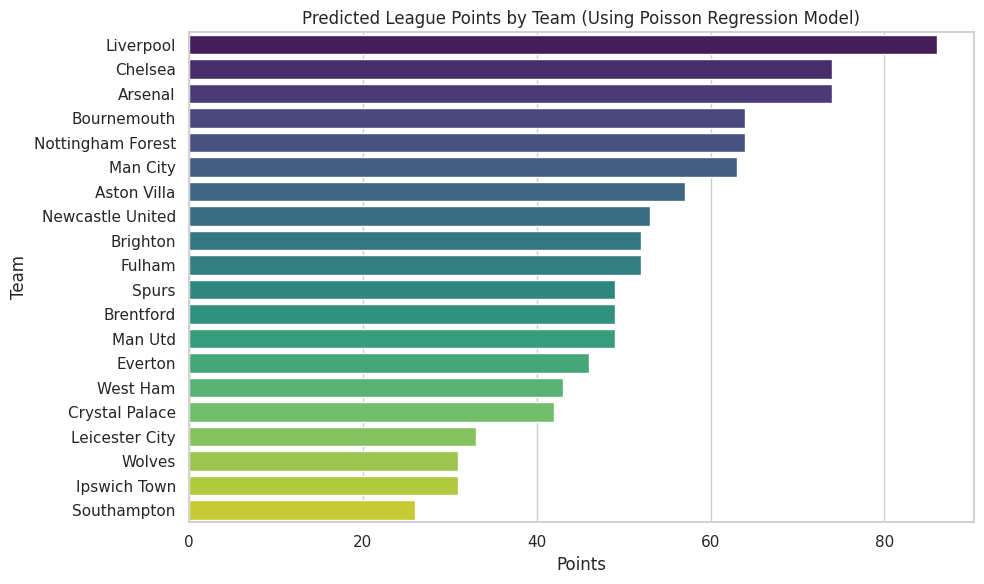

In [10]:
# Convert standings dictionary back to DataFrame
predicted_standings_model = pd.DataFrame.from_dict(standings_dict, orient='index').reset_index().rename(columns={'index': 'Team'})

# Sort standings: first by Points, then Goal Difference, then Goals For
predicted_standings_model = predicted_standings_model.sort_values(by=['Points', 'GD', 'F'], ascending=False).reset_index(drop=True)
predicted_standings_model.index += 1  # Ranking starts at 1
predicted_standings_model.insert(0, 'Rank', predicted_standings_model.index)

print("\nPredicted League Standings (Model-Based Simulation):")
print(predicted_standings_model)

# Visualize predicted points for each team
plt.figure(figsize=(10, 6))
sns.barplot(x='Points', y='Team', data=predicted_standings_model, palette='viridis')
plt.title("Predicted League Points by Team (Using Poisson Regression Model)")
plt.xlabel("Points")
plt.ylabel("Team")
plt.tight_layout()
plt.show()


In [21]:
# ==========================================================
# Section 11: Evaluate Model Performance on Historical Data
# ==========================================================
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def predict_match_outcome(home_team, away_team):
    """
    Predict the outcome of a match as a categorical result:
    'H' for home win, 'D' for draw, and 'A' for away win.

    Uses the simulate_match_model function to generate a simulated result.
    """
    # Generate a simulated match result using the previously defined function.
    pred_home, pred_away = simulate_match_model(home_team, away_team,
                                                poisson_model_home, poisson_model_away,
                                                teams_train, league_avg_home_goals, league_avg_away_goals)
    # Determine predicted outcome
    if pred_home > pred_away:
        return 'H'
    elif pred_home == pred_away:
        return 'D'
    else:
        return 'A'

# Apply the prediction function to the historical matches dataset.
# This will create a new column 'PredictedFTR' in the 'matches' DataFrame.
matches['PredictedFTR'] = matches.apply(lambda row: predict_match_outcome(row['HomeTeam'], row['AwayTeam']), axis=1)

# Extract actual outcomes.
# Assumes that the historical results dataset has a column 'FTR' with values:
# 'H' for home win, 'D' for draw, and 'A' for away win.
actual_outcomes = matches['FTR']
predicted_outcomes = matches['PredictedFTR']

# Calculate evaluation metrics.
accuracy = accuracy_score(actual_outcomes, predicted_outcomes)
conf_matrix = confusion_matrix(actual_outcomes, predicted_outcomes)
class_report = classification_report(actual_outcomes, predicted_outcomes)

print("Model Accuracy on Historical Data:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Model Accuracy on Historical Data: 0.43093514551632445

Confusion Matrix:
[[ 808  467  725]
 [ 540  434  695]
 [ 750  675 1675]]

Classification Report:
              precision    recall  f1-score   support

           A       0.39      0.40      0.39      2000
           D       0.28      0.26      0.27      1669
           H       0.54      0.54      0.54      3100

    accuracy                           0.43      6769
   macro avg       0.40      0.40      0.40      6769
weighted avg       0.43      0.43      0.43      6769



In [24]:
# Extract the starting year from 'Season' column
matches['Start_Year'] = matches['Season'].apply(lambda x: int(x.split('-')[0]))

# Verify conversion
print(matches[['Season', 'Start_Year']].head())


    Season  Start_Year
0  2004-05        2004
1  2004-05        2004
2  2004-05        2004
3  2004-05        2004
4  2004-05        2004


In [25]:
# Define training and test data
train_data = matches[matches['Start_Year'] <= 2020]  # Training data (2004-05 to 2020-21)
test_data = matches[matches['Start_Year'] == 2021]   # Testing data (2021-22)

# Check the shapes
print(f"Training Data Shape: {train_data.shape}")
print(f"Test Data Shape: {test_data.shape}")


Training Data Shape: (6460, 25)
Test Data Shape: (309, 25)


In [26]:
# Predict outcomes for test data (2021-22)
predicted_outcomes = test_data.apply(
    lambda row: predict_match_outcome(row['HomeTeam'], row['AwayTeam']), axis=1
)

# Actual results from the dataset
actual_outcomes = test_data['FTR']  # 'FTR' (Full-Time Result) contains actual match outcomes


In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Accuracy
accuracy = accuracy_score(actual_outcomes, predicted_outcomes)

# Precision, Recall, and F1-score
precision = precision_score(actual_outcomes, predicted_outcomes, average='macro')  # Use 'macro' for balanced classes
recall = recall_score(actual_outcomes, predicted_outcomes, average='macro')
f1 = f1_score(actual_outcomes, predicted_outcomes, average='macro')

# Confusion Matrix
conf_matrix = confusion_matrix(actual_outcomes, predicted_outcomes)

# Classification Report
class_report = classification_report(actual_outcomes, predicted_outcomes)

# Print Results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


Accuracy: 0.43
Precision: 0.41
Recall: 0.41
F1 Score: 0.41
Confusion Matrix:
 [[44 21 42]
 [22 22 28]
 [32 32 66]]
Classification Report:
               precision    recall  f1-score   support

           A       0.45      0.41      0.43       107
           D       0.29      0.31      0.30        72
           H       0.49      0.51      0.50       130

    accuracy                           0.43       309
   macro avg       0.41      0.41      0.41       309
weighted avg       0.43      0.43      0.43       309

